In [1]:
from pathlib import Path
import re

import itertools
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

In [2]:
plt.rcParams.update({'font.size': 12})
plt.rc('legend',fontsize=12, title_fontsize=12) # using a named size

In [3]:
params_pattern = r"python -u run_merlin.py --workflow-dir /scratch/shared/pwesolowski/mgr-pipeline/merlin/ --blocksize ([^\s]+) --data-path /scratch/shared/pwesolowski/mgr-pipeline/joined-recommender --parts-per-chunk ([^\s]+) (--force-host-read|--cufile-thread-count ([^\s]+)) --batch-size ([^\s]+) --epochs 5'"

In [4]:
path = "slurm-693967.out"

In [5]:
with open(path) as f:
    logs = f.read()

In [6]:
def parse_blocksize(text):
    return {
        "512MiB": 0.5,
        "1GiB": 1,
        "2GiB": 2
    }[text]

param_matches = list(re.finditer(params_pattern, logs))

measurements = []
for m, next_m in itertools.zip_longest(param_matches, param_matches[1:]):
    score_pattern = r"Code block '([^\s]+) epoch=([^\s]+)' took: ([^\s]+) ms"
    scores = re.findall(score_pattern, logs[m.end():(next_m.start() if next_m is not None else None)])
    for score in scores:
        measurements.append({
            "blocksize (GiB)": parse_blocksize(m.group(1)),
            "parts_per_chunk": int(m.group(2)),
            "GDS": m.group(3) != "--force-host-read",
            "number of\nIO threads": int(m.group(4)) if m.group(4) is not None else 0,
            "batch_size": int(m.group(5)),
            "subset": score[0],
            "epoch": int(score[1]),
            "time (msecs)": float(score[2])
        })
measurements_df = pd.DataFrame(measurements)

In [7]:
measurements_df = measurements_df.loc[measurements_df.groupby(["blocksize (GiB)", "parts_per_chunk", "number of\nIO threads", "batch_size"], dropna=False)["subset"].transform(lambda x: x.nunique()).gt(1), :]

In [8]:
type(measurements_df.iloc[223]["number of\nIO threads"])

numpy.int64

In [9]:
measurements_df["number of\nIO threads"].unique()

array([ 0,  4,  8, 16, 32, 64])

In [10]:
measurements_df = measurements_df[measurements_df.epoch > 0]
measurements_df = measurements_df[~measurements_df["number of\nIO threads"].isin([8, 32])]

In [11]:
measurements_df["number of\nIO threads"] = measurements_df["number of\nIO threads"].replace(0, "No GDS")

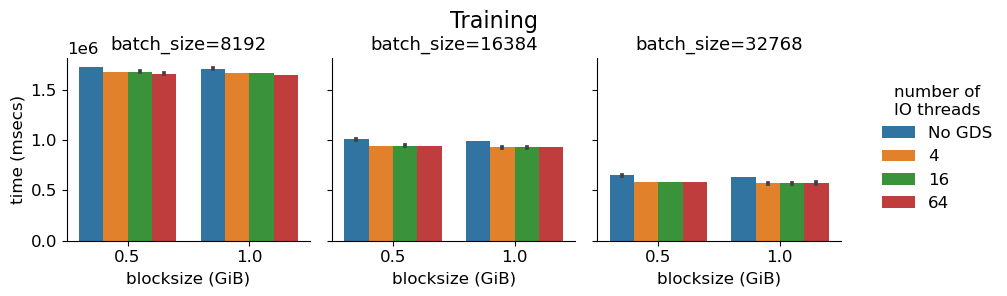

In [12]:
g = sns.FacetGrid(measurements_df[measurements_df.subset == "train"], col="batch_size", margin_titles=True)
g.set_titles(col_template="batch_size={col_name}", size=13)
g.map_dataframe(
    sns.barplot, x="blocksize (GiB)", y="time (msecs)", hue="number of\nIO threads",
    palette=sns.color_palette(n_colors=measurements_df["number of\nIO threads"].nunique())
)
g.add_legend(title="number of\nIO threads")
g.figure.suptitle("Training", size=16)
g.figure.subplots_adjust(top=.82)
plt.savefig(f"img/comparison-GDS-train.pdf", format="pdf", bbox_inches='tight')
plt.show()

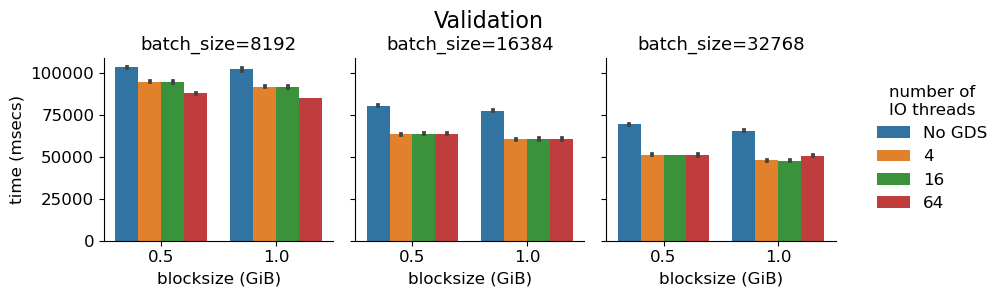

In [13]:
g = sns.FacetGrid(measurements_df[measurements_df.subset == "val"], col="batch_size", margin_titles=True)
g.set_titles(col_template="batch_size={col_name}", size=13)
g.map_dataframe(
    sns.barplot, x="blocksize (GiB)", y="time (msecs)", hue="number of\nIO threads",
    palette=sns.color_palette(n_colors=measurements_df["number of\nIO threads"].nunique())
)
g.add_legend(title="number of\nIO threads")
g.figure.suptitle("Validation", size=16)
g.figure.subplots_adjust(top=.82)
plt.savefig(f"img/comparison-GDS-val.pdf", format="pdf", bbox_inches='tight')
plt.show()